In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os

import numpy as np
from imageio import imread, imwrite
from skimage.measure import compare_ssim

import torch
import torch.nn
from torchvision.models.vgg import vgg19

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import vggfusiongpu as fu

from skimage import morphology

from filters import *

In [3]:
model = vgg19(True).cuda().eval()

In [4]:
def fuse_twoscale(V, I, **kwargs):
    with_exp = kwargs.get('with_exp', True)
    kernel = kwargs.get('kernel', 45)
    r1 = kwargs.get('r1', 45)
    eps1 = kwargs.get('eps1', 0.01)
    r2 = kwargs.get('r2', 7)
    eps2 = kwargs.get('eps2', 10e-6)
    layer = kwargs.get('layer', 2)
    
    k = (kernel, kernel)
    
    # Decomposition
    V = vis / 255.
    Bv = cv2.blur(V, k) 
    Dv = V - Bv

    I = ir / 255.
    Bi = cv2.blur(I, k)
    Di = I - Bi
    
    # Base Fusion
    P1 = SalWeights([vis, ir])
    P1 = [P1[:,:,0], P1[:,:,1]]
    Wb = GuidedOptimize([V, I], P1, r1, eps1)
    fT2 = FuseWeights([Bv, Bi], Wb)

    # Detail Fusion
    DT = fu.fuse([Dv, Di], model, with_exp=with_exp, layer_number=layer)
    Wd = DT[0].cpu().numpy()
    fT1 = FuseWeights([Dv, Di], np.dstack(Wd))
    
    # Reconstruction
    fT = fT2 + fT1
    fT = np.clip(fT, 0, 1)
    fT = (fT*255).astype(np.uint8)
    
    return fT

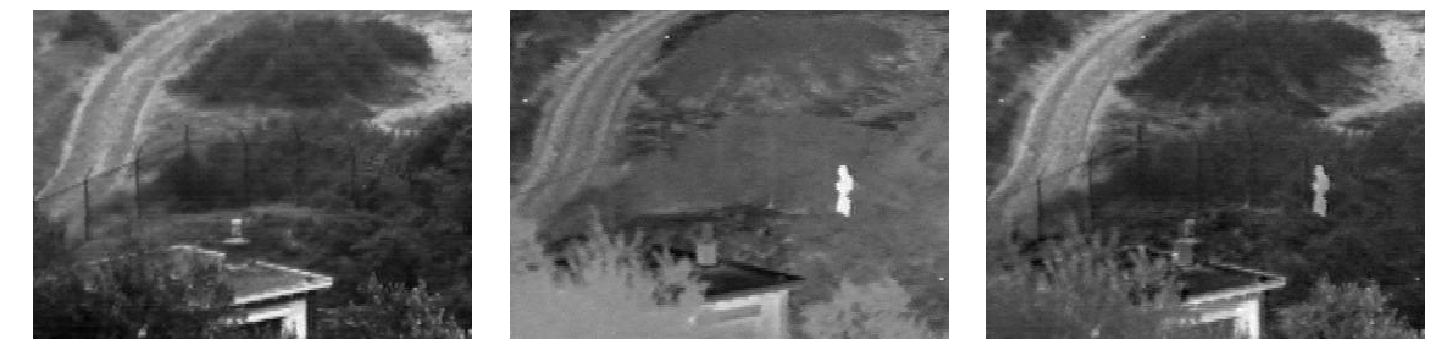

In [8]:
vis = imread('images/VIS1.png')
ir = imread('images/IR1.png')
    
fT = fuse_twoscale(vis, ir)

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.imshow(vis, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(ir, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(fT, cmap='gray')
plt.axis('off')